#Model 2 (SigNet)

In [ ]:
from h5py import File
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import permutation, randint, rand
import os
from tensorflow.keras.initializers import RandomNormal, Constant
import tensorflow as tf
from tensorflow.keras.backend import max, mean, sqrt, square, sum
import seaborn as sns
from tensorflow.keras.optimizers import Adam,RMSprop
from keras.models import Model

from tensorflow import keras
from keras.layers import LeakyReLU, Softmax
from keras.layers import Conv2D, Activation, Input,Dropout,Lambda,Flatten, Dense
from keras.layers import Dense, Flatten, Reshape, Activation
from keras.layers import BatchNormalization ,ZeroPadding2D

from keras.layers import MaxPooling2D
from keras.layers import Concatenate
from keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from keras.layers import Layer, InputSpec
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow import one_hot, reshape

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with tf.device('/device:GPU:0'):
  colab = True
  # database = 'bigsig260_224x224_siamese_preprocessed.h5'
  if colab:
      # from google.colab import drive
      # drive.mount('/content/gdrive')
      file = '/content/drive/MyDrive/BHsigHindi224x224_siamese_preprocessed.h5'
  else:
      file = os.path.join(os.getcwd(),'RoboticLab', database)
  print(file)
  with File(file, 'r') as hdf:
      S1 = np.array(hdf.get('S1'))
      S2 = np.array(hdf.get('S2'))
      Y = np.array(hdf.get('Y'))
  print(S1.shape)
  print(S2.shape)
  print(Y.shape)

/content/drive/MyDrive/BHsigHindi224x224_siamese_preprocessed.h5
(29880, 224, 224, 1)
(29880, 224, 224, 1)
(29880, 1)


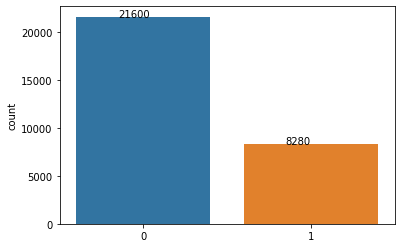

In [ ]:
ax = sns.countplot(x = Y.reshape(Y.shape[0]))
for p in ax.patches:
   ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

In [ ]:

import sklearn
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(Y),y = Y.reshape(Y.shape[0]))
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.6916666666666667, 1: 1.8043478260869565}

In [ ]:
Y = Y/1.0

In [ ]:
with tf.device('/device:GPU:0'):
  seed=randint(10)
  print('seed='+str(seed))
  indices = permutation(Y.shape[0])
  m = int(0.70 * Y.shape[0])
  n = int(0.15 * Y.shape[0])
  training_id, validation_id, test_id = indices[:m], indices[m: m + n], indices[m+n:]
  S1_train, S1_test, S1_validate = S1[training_id], S1[test_id], S1[validation_id]
  S2_train, S2_test, S2_validate = S2[training_id], S2[test_id], S2[validation_id]
  Y_train, Y_test, Y_validate = Y[training_id], Y[test_id], Y[validation_id]
  print(S1_train.shape)
  print(S2_train.shape)
  print(Y_train.shape)

  del S1,S2,Y

seed=1
(20916, 224, 224, 1)
(20916, 224, 224, 1)
(20916, 1)


In [ ]:
#One hot Encoding
Y_train = one_hot(Y_train, depth=2)
Y_train = reshape(Y_train, (-1, 2))

Y_test = one_hot(Y_test, depth=2)
Y_test = reshape(Y_test, (-1, 2))

Y_validate = one_hot(Y_validate, depth=2)
Y_validate = reshape(Y_validate, (-1, 2))

In [ ]:
with tf.device('/device:GPU:0'):
  def SigNet(input_shape):

    seq = keras.Sequential()
    seq.add(Conv2D(96, kernel_size = 11, strides =  1, activation='relu', name='conv1_1', input_shape= input_shape,
                        kernel_initializer='glorot_uniform',data_format='channels_first',padding = "same"))
    seq.add(BatchNormalization(epsilon=1e-04,  axis=1, momentum=0.9))
    seq.add(MaxPooling2D(3, strides=2,padding = "same"))

    seq.add(Conv2D(256, kernel_size =  5,strides =  1, activation='relu', name='conv2_1', kernel_initializer='glorot_uniform'
    ,data_format='channels_first',padding = "same"))
    seq.add(BatchNormalization(epsilon=1e-04 , momentum=0.9))
    seq.add(MaxPooling2D(3, strides=2,padding = "same"))
    seq.add(Dropout(0.3))

    seq.add(Conv2D(384, kernel_size =  3,strides =  3, activation='relu', name='conv3_1', kernel_initializer='glorot_uniform'
    ,data_format='channels_first',padding = "same"))

    seq.add(Conv2D(256, kernel_size =  3, strides =  3, activation='relu', name='conv3_2', kernel_initializer='glorot_uniform'
    ,data_format='channels_first',padding = "same"))
    seq.add(MaxPooling2D(3, strides=2,padding = "same"))
    seq.add(Dropout(0.5))
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024 , activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(Dropout(0.3))
    seq.add(Dense(128, activation='relu', kernel_initializer='glorot_uniform')) # softmax changed to relu

    return seq

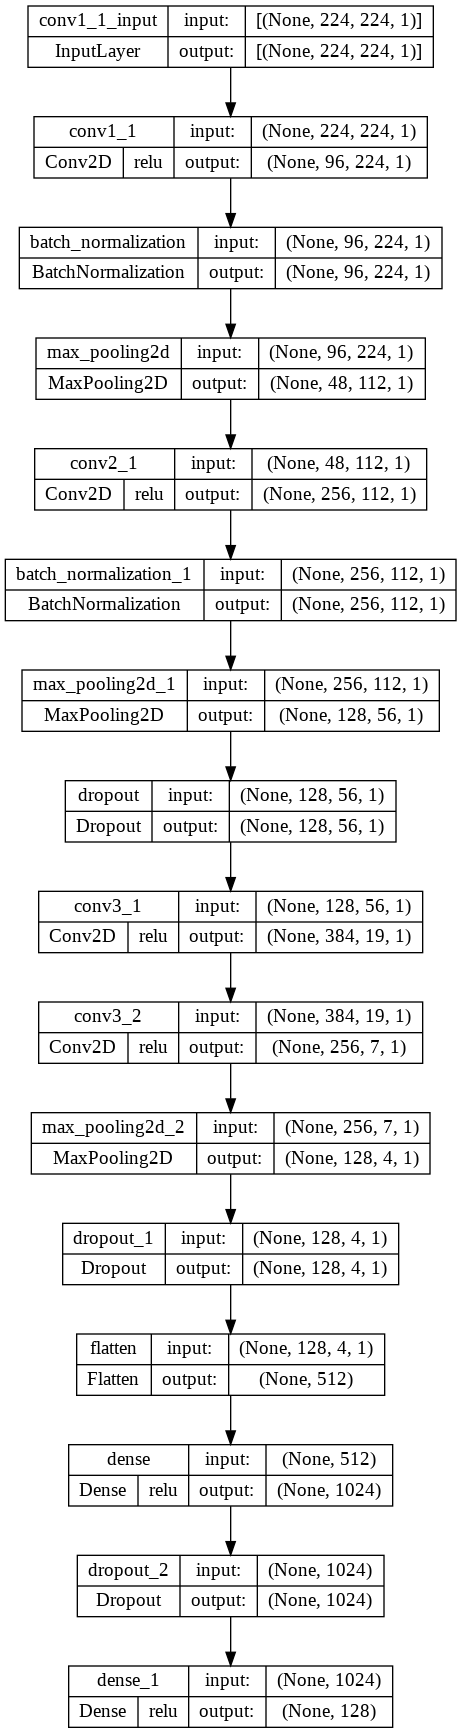

In [ ]:
plot_model(SigNet(input_shape=(224, 224, 1)), show_shapes=True,show_layer_activations = True)

In [ ]:
with tf.device('/device:GPU:0'):
  inputShape = S1_train.shape[1:]
  f = SigNet(inputShape)

In [ ]:
def euclidean_distance(S):
  X = S['S1']
  Y = S['S2']
  return K.sqrt(K.maximum(K.sum(K.square(X - Y), axis=1, keepdims=True), K.epsilon()))

In [ ]:
with tf.device('/device:GPU:0'):
  input_a = Input(shape=inputShape, name = 'S1')
  input_b = Input(shape=inputShape, name = 'S2')
  encoded_s1 = f(input_a)
  encoded_s2 = f(input_b)
  distance = Lambda(euclidean_distance)({'S1': encoded_s1, 'S2': encoded_s2})
  model = Model(inputs = [input_a, input_b], outputs = distance)

In [ ]:
def constructive_loss(y_true, y_pred):
  margin = 1
  y_true = tf.cast(y_true, y_pred.dtype)
  squaredPreds = K.square(y_pred)
  squaredMargin = K.square(K.maximum(margin - y_pred, 0))
  loss = K.mean(y_true * squaredMargin + (1 - y_true) * squaredPreds)
  return loss

## **HYPER PARAMETER TUNING**

## **BATCH SIZE TUNING**

In [ ]:
# with tf.device('/device:GPU:0'):
#   for i in np.arange(0.0010,0.0101,0.0010):
#     adam = Adam(learning_rate = 0.001,epsilon = 1e-08)
#     model.compile(loss = constructive_loss, optimizer = adam, metrics=['BinaryAccuracy'])
#     print("For Learning Rate = {LR}".format(LR = i))


In [ ]:
with tf.device('/device:GPU:0'):
  adam = Adam(learning_rate = 0.001,epsilon = 1e-08)
  model.compile(loss = constructive_loss, optimizer = adam, metrics=['BinaryAccuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  batch_Size = 8
  print("For batch Size : ",batch_Size)
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 1,batch_size = batch_Size,,class_weight = class_weight_dict,shuffle = True
                        )

For batch Size :  8
2802/2802 [==============================] - 213s 72ms/step - loss: 0.0934 - binary_accuracy: 0.9104 - val_loss: 0.0813 - val_binary_accuracy: 0.9186


In [ ]:
with tf.device('/device:GPU:0'):
  batch_Size = 16
  print("For batch Size : ",batch_Size)
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 1,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For batch Size :  16
1401/1401 [==============================] - 160s 107ms/step - loss: 0.0904 - binary_accuracy: 0.9103 - val_loss: 0.0883 - val_binary_accuracy: 0.9116


In [ ]:
with tf.device('/device:GPU:0'):
  batch_Size = 32
  print("For batch Size : ",batch_Size)
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 1,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For batch Size :  32
701/701 [==============================] - 132s 172ms/step - loss: 0.0979 - binary_accuracy: 0.9093 - val_loss: 0.0795 - val_binary_accuracy: 0.9205


In [ ]:
with tf.device('/device:GPU:0'):
  batch_Size = 64
  print("For batch Size : ",batch_Size)
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 1,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For batch Size :  64
351/351 [==============================] - 120s 311ms/step - loss: 0.0908 - binary_accuracy: 0.9108 - val_loss: 0.0768 - val_binary_accuracy: 0.9232


In [ ]:
with tf.device('/device:GPU:0'):
  batch_Size = 128
  print("For batch Size : ",batch_Size)
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 1,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For batch Size :  128
176/176 [==============================] - 118s 605ms/step - loss: 0.0928 - binary_accuracy: 0.9084 - val_loss: 0.0779 - val_binary_accuracy: 0.9221


**THE BEST ACCURACY IS FOR BATCH SIZE = 64**

## **LEARNING RATE**

In [ ]:
batch_Size = 32

In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-04
  print("For learning Rate = ",lr)
  SGD = tf.keras.optimizers.SGD(learning_rate = lr,momentum = 0.9)
  model.compile(loss = constructive_loss, optimizer = SGD, metrics=['BinaryAccuracy'])
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For learning Rate =  0.0001
Epoch 1/5
229/654 [=========>....................] - ETA: 33s - loss: 0.2544 - binary_accuracy: 0.5000

KeyboardInterrupt: ignored

In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-03
  print("For learning Rate = ",lr)
  rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
  model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy'])
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For learning Rate =  0.001
Epoch 1/5
654/654 [==============================] - 36s 39ms/step - loss: 0.2937 - binary_accuracy: 0.7216 - val_loss: 0.2698 - val_binary_accuracy: 0.7300
Epoch 2/5
654/654 [==============================] - 24s 37ms/step - loss: 0.2827 - binary_accuracy: 0.7234 - val_loss: 0.2698 - val_binary_accuracy: 0.7300
Epoch 3/5
654/654 [==============================] - 25s 38ms/step - loss: 0.2834 - binary_accuracy: 0.7234 - val_loss: 0.2698 - val_binary_accuracy: 0.7300
Epoch 4/5
654/654 [==============================] - 24s 37ms/step - loss: 0.2838 - binary_accuracy: 0.7234 - val_loss: 0.2698 - val_binary_accuracy: 0.7300
Epoch 5/5
654/654 [==============================] - 24s 37ms/step - loss: 0.2837 - binary_accuracy: 0.7234 - val_loss: 0.2698 - val_binary_accuracy: 0.7300


In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-04
  print("For learning Rate = ",lr)
  rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
  model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy'])
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For learning Rate =  0.0001
Epoch 1/5
654/654 [==============================] - 36s 39ms/step - loss: 0.2232 - binary_accuracy: 0.7001 - val_loss: 0.2445 - val_binary_accuracy: 0.7129
Epoch 2/5
654/654 [==============================] - 25s 38ms/step - loss: 0.2047 - binary_accuracy: 0.7146 - val_loss: 0.2358 - val_binary_accuracy: 0.7140
Epoch 3/5
654/654 [==============================] - 25s 38ms/step - loss: 0.2008 - binary_accuracy: 0.7189 - val_loss: 0.2318 - val_binary_accuracy: 0.7115
Epoch 4/5
654/654 [==============================] - 24s 37ms/step - loss: 0.1992 - binary_accuracy: 0.7188 - val_loss: 0.2352 - val_binary_accuracy: 0.7146
Epoch 5/5
654/654 [==============================] - 24s 37ms/step - loss: 0.1935 - binary_accuracy: 0.7259 - val_loss: 0.2279 - val_binary_accuracy: 0.7149


In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-05
  print("For learning Rate = ",lr)
  rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
  model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy'])
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For learning Rate =  1e-05
Epoch 1/5
654/654 [==============================] - 33s 35ms/step - loss: 0.2488 - binary_accuracy: 0.7070 - val_loss: 0.2451 - val_binary_accuracy: 0.7135
Epoch 2/5
654/654 [==============================] - 22s 34ms/step - loss: 0.1971 - binary_accuracy: 0.7212 - val_loss: 0.2483 - val_binary_accuracy: 0.7135
Epoch 3/5
654/654 [==============================] - 23s 35ms/step - loss: 0.1953 - binary_accuracy: 0.7240 - val_loss: 0.2338 - val_binary_accuracy: 0.7135
Epoch 4/5
654/654 [==============================] - 22s 34ms/step - loss: 0.1947 - binary_accuracy: 0.7232 - val_loss: 0.2389 - val_binary_accuracy: 0.7124
Epoch 5/5
654/654 [==============================] - 22s 34ms/step - loss: 0.1917 - binary_accuracy: 0.7255 - val_loss: 0.2385 - val_binary_accuracy: 0.7135


In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-06
  print("For learning Rate = ",lr)
  rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
  model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy' ])
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For learning Rate =  1e-06
Epoch 1/5
654/654 [==============================] - 26s 36ms/step - loss: 0.2219 - binary_accuracy: 0.6782 - val_loss: 0.2373 - val_binary_accuracy: 0.7160
Epoch 2/5
654/654 [==============================] - 22s 34ms/step - loss: 0.1969 - binary_accuracy: 0.7241 - val_loss: 0.2315 - val_binary_accuracy: 0.7160
Epoch 3/5
654/654 [==============================] - 22s 34ms/step - loss: 0.1910 - binary_accuracy: 0.7257 - val_loss: 0.2267 - val_binary_accuracy: 0.7160
Epoch 4/5
654/654 [==============================] - 25s 39ms/step - loss: 0.1865 - binary_accuracy: 0.7283 - val_loss: 0.2198 - val_binary_accuracy: 0.7160
Epoch 5/5
202/654 [========>.....................] - ETA: 14s - loss: 0.1819 - binary_accuracy: 0.7333

KeyboardInterrupt: ignored

In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-07
  print("For learning Rate = ",lr)
  rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
  model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy'])
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For learning Rate =  1e-07
Epoch 1/5
654/654 [==============================] - 32s 37ms/step - loss: 2.3212 - binary_accuracy: 0.2760 - val_loss: 0.2162 - val_binary_accuracy: 0.7115
Epoch 2/5
654/654 [==============================] - 23s 34ms/step - loss: 0.4720 - binary_accuracy: 0.3013 - val_loss: 0.2243 - val_binary_accuracy: 0.7135
Epoch 3/5
654/654 [==============================] - 22s 34ms/step - loss: 0.2376 - binary_accuracy: 0.6079 - val_loss: 0.2404 - val_binary_accuracy: 0.7135
Epoch 4/5
654/654 [==============================] - 22s 34ms/step - loss: 0.2098 - binary_accuracy: 0.7163 - val_loss: 0.2480 - val_binary_accuracy: 0.7135
Epoch 5/5
654/654 [==============================] - 22s 34ms/step - loss: 0.2044 - binary_accuracy: 0.7230 - val_loss: 0.2509 - val_binary_accuracy: 0.7135


In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-08
  print("For learning Rate = ",lr)
  rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
  model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy'])
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For learning Rate =  1e-08
Epoch 1/5
654/654 [==============================] - 29s 42ms/step - loss: 0.1911 - binary_accuracy: 0.7238 - val_loss: 0.2165 - val_binary_accuracy: 0.7320
Epoch 2/5
654/654 [==============================] - 25s 38ms/step - loss: 0.1907 - binary_accuracy: 0.7241 - val_loss: 0.2162 - val_binary_accuracy: 0.7320
Epoch 3/5
654/654 [==============================] - 25s 38ms/step - loss: 0.1910 - binary_accuracy: 0.7238 - val_loss: 0.2154 - val_binary_accuracy: 0.7320
Epoch 4/5
654/654 [==============================] - 25s 38ms/step - loss: 0.1914 - binary_accuracy: 0.7238 - val_loss: 0.2154 - val_binary_accuracy: 0.7320
Epoch 5/5
654/654 [==============================] - 25s 38ms/step - loss: 0.1908 - binary_accuracy: 0.7241 - val_loss: 0.2160 - val_binary_accuracy: 0.7320


## **FINAL TRAINING**

***BEST LEARNING RATE IS 1e-04***

In [ ]:
Batch_size = 32
lr = 1e-04
Epochs = 60

In [ ]:
with tf.device('/device:GPU:0'):
    rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
    model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy','AUC'])

In [ ]:
with tf.device('/device:GPU:0'):
  callbacks = [
    EarlyStopping(patience = 6, verbose = 1),
    ModelCheckpoint('/content/drive/MyDrive/HindiSigNet(1e-04)DataEpochs60/bhsig260-{epoch:03d}.h5'
    , verbose=1,save_best_only = True)
]


In [ ]:
with tf.device('/device:GPU:0'):
  results = model.fit(x = [S1_train, S2_train],y = Y_train,
                    validation_data = ([S1_validate,S2_validate],Y_validate),
                    epochs = Epochs,callbacks = callbacks,batch_size = Batch_size
                    ,class_weight = class_weight_dict,shuffle = True
                    )

Epoch 1/60
654/654 [==============================] - ETA: 0s - loss: 0.2307 - binary_accuracy: 0.6978
Epoch 1: val_loss improved from inf to 0.23711, saving model to /content/drive/MyDrive/HindiSigNet(1e-04)DataEpochs60/bhsig260-001.h5
654/654 [==============================] - 34s 39ms/step - loss: 0.2307 - binary_accuracy: 0.6978 - val_loss: 0.2371 - val_binary_accuracy: 0.7164
Epoch 2/60
654/654 [==============================] - ETA: 0s - loss: 0.2083 - binary_accuracy: 0.7125
Epoch 2: val_loss did not improve from 0.23711
654/654 [==============================] - 25s 38ms/step - loss: 0.2083 - binary_accuracy: 0.7125 - val_loss: 0.2376 - val_binary_accuracy: 0.7153
Epoch 3/60
654/654 [==============================] - ETA: 0s - loss: 0.2024 - binary_accuracy: 0.7154
Epoch 3: val_loss improved from 0.23711 to 0.23053, saving model to /content/drive/MyDrive/HindiSigNet(1e-04)DataEpochs60/bhsig260-003.h5
654/654 [==============================] - 25s 39ms/step - loss: 0.2024 - bina

In [ ]:
import pickle

In [ ]:
with open('/content/drive/MyDrive/HindiSigNet(1e-04)DataEpochs60/trainHistoryDict', 'wb') as file_pi:
      #  pickle.dump(results.history, file_pi)

In [ ]:
import pickle
history = pickle.load(open('/content/drive/MyDrive/HindiSigNet(1e-04)DataEpochs60/trainHistoryDict', "rb"))

In [ ]:
history['val_loss'].index(min(history['val_loss'])) + 1

17

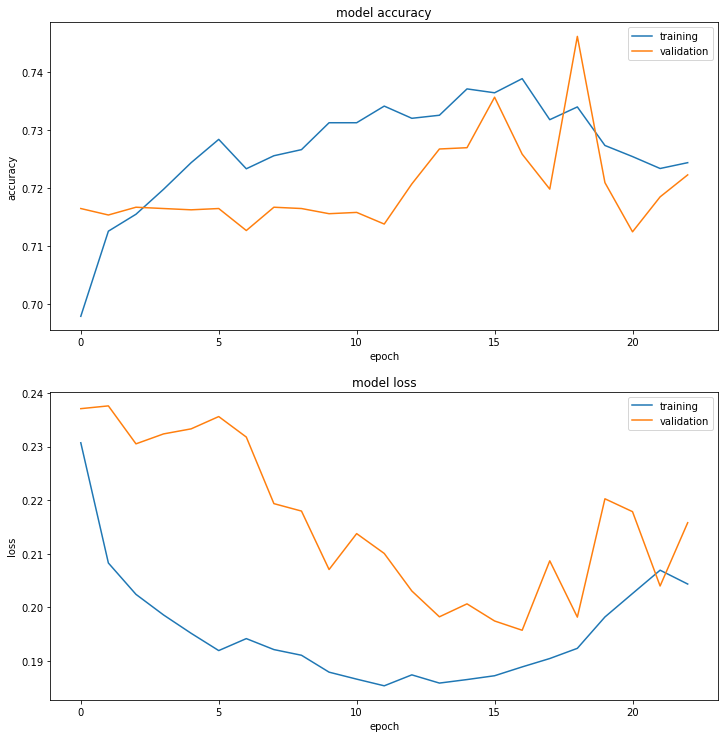

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history['binary_accuracy'], history['val_binary_accuracy'], 'accuracy', 211)
display_training_curves(history['loss'], history['val_loss'], 'loss', 212)

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(Y_test, tf.argmax(model.predict(X_test),axis = 1))).plot()
plt.savefig(folder + "confusionmatrix.jpeg")
plt.show()